In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import GradientBoostingClassifier
from scipy import stats
from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression
from scipy.spatial.distance import squareform, pdist
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from matplotlib import pyplot as plt

In [2]:
#The data
pd.set_option('display.max_columns', None)
math_data = pd.read_csv("student-mat.csv")
por_data = pd.read_csv("student-por.csv")

math_data = math_data[math_data['age'] < 20]
por_data = por_data[por_data['age'] < 20]

# definitions from the preprocessing part
threshold = 8
math_data['T'] = ((math_data['absences']) >= threshold).astype(int)
por_data['T'] = ((por_data['absences']) >= threshold).astype(int)

math_data['Y'] = (math_data['G1'] + math_data['G2'] + math_data['G3']) / 3
por_data['Y'] = (por_data['G1'] + por_data['G2'] + por_data['G3']) / 3

udf = pd.concat([math_data, por_data])
sampled_df = udf.groupby(["school", "sex", "age", "address", "famsize", "Pstatus", "Medu", "Fedu", "Mjob", "Fjob", "reason", "internet"])
sampled_df = sampled_df.apply(lambda x: x.sample(n=1, random_state=12))

sampled_df = sampled_df.drop("absences", axis='columns')
sampled_df

school  \
school sex age address famsize Pstatus Medu Fedu Mjob     Fjob     reason     internet              
GP     F   15  R       GT3     T       1    1    at_home  other    home       yes      95      GP   
                                                 other    other    course     yes      148     GP   
                                                                   reputation yes      72      GP   
                                       2    2    at_home  other    reputation no       39      GP   
                                            4    services health   course     yes      24      GP   
...                                                                                           ...   
MS     M   19  R       GT3     T       1    1    other    services other      no       383     MS   
               U       GT3     T       1    1    other    other    other      yes      552     MS   
                                       2    1    at_home  other    course     yes      571     MS   
                                       3    2    at_home  services course     no       568     MS   
                       LE3     T       1    1    other    at_home  course     yes      394     MS   

                                                                                           sex  \
school sex age address famsize Pstatus Medu Fedu Mjob     Fjob     reason     internet           
GP     F   15  R       GT3     T       1    1    at_home  other    home       yes      95    F   
                                                 other    other    course     yes      148   F   
                                                                   reputation yes      72    F   
                                       2    2    at_home  other    reputation no       39    F   
                                            4    services health   course     yes      24    F   
...                                                                                         ..   
MS     M   19  R       GT3     T       1    1    other    services other      no       383   M   
               U       GT3     T       1    1    other    other    other      yes      552   M   
                                       2    1    at_home  other    course     yes      571   M   
                                       3    2    at_home  services course     no       568   M   
                       LE3     T       1    1    other    at_home  course     yes      394   M   

                                                                                            age  \
school sex age address famsize Pstatus Medu Fedu Mjob     Fjob     reason     internet            
GP     F   15  R       GT3     T       1    1    at_home  other    home       yes      95    15   
                                                 other    other    course     yes      148   15   
                                                                   reputation yes      72    15   
                                       2    2    at_home  other    reputation no       39    15   
                                            4    services health   course     yes      24    15   
...                                                                                         ...   
MS     M   19  R       GT3     T       1    1    other    services other      no       383   19   
               U       GT3     T       1    1    other    other    other      yes      552   19   
                                       2    1    at_home  other    course     yes      571   19   
                                       3    2    at_home  services course     no       568   19   
                       LE3     T       1    1    other    at_home  course     yes      394   19   

                                                                                           address  \
school sex age address famsize Pstatus Medu Fedu Mjob     Fjob     reason     internet               
GP     F  

In [3]:
#Before applying models on the data we will transform all the categorical features to numerical
categorical_cols = sampled_df.select_dtypes(['object']).columns
sampled_df[categorical_cols] = sampled_df[categorical_cols].apply(lambda x: pd.factorize(x)[0])
sampled_df

school  \
school sex age address famsize Pstatus Medu Fedu Mjob     Fjob     reason     internet               
GP     F   15  R       GT3     T       1    1    at_home  other    home       yes      95        0   
                                                 other    other    course     yes      148       0   
                                                                   reputation yes      72        0   
                                       2    2    at_home  other    reputation no       39        0   
                                            4    services health   course     yes      24        0   
...                                                                                            ...   
MS     M   19  R       GT3     T       1    1    other    services other      no       383       1   
               U       GT3     T       1    1    other    other    other      yes      552       1   
                                       2    1    at_home  other    course     yes      571       1   
                                       3    2    at_home  services course     no       568       1   
                       LE3     T       1    1    other    at_home  course     yes      394       1   

                                                                                            sex  \
school sex age address famsize Pstatus Medu Fedu Mjob     Fjob     reason     internet            
GP     F   15  R       GT3     T       1    1    at_home  other    home       yes      95     0   
                                                 other    other    course     yes      148    0   
                                                                   reputation yes      72     0   
                                       2    2    at_home  other    reputation no       39     0   
                                            4    services health   course     yes      24     0   
...                                                                                         ...   
MS     M   19  R       GT3     T       1    1    other    services other      no       383    1   
               U       GT3     T       1    1    other    other    other      yes      552    1   
                                       2    1    at_home  other    course     yes      571    1   
                                       3    2    at_home  services course     no       568    1   
                       LE3     T       1    1    other    at_home  course     yes      394    1   

                                                                                            age  \
school sex age address famsize Pstatus Medu Fedu Mjob     Fjob     reason     internet            
GP     F   15  R       GT3     T       1    1    at_home  other    home       yes      95    15   
                                                 other    other    course     yes      148   15   
                                                                   reputation yes      72    15   
                                       2    2    at_home  other    reputation no       39    15   
                                            4    services health   course     yes      24    15   
...                                                                                         ...   
MS     M   19  R       GT3     T       1    1    other    services other      no       383   19   
               U       GT3     T       1    1    other    other    other      yes      552   19   
                                       2    1    at_home  other    course     yes      571   19   
                                       3    2    at_home  services course     no       568   19   
                       LE3     T       1    1    other    at_home  course     yes      394   19   

                                                                                            address  \
school sex age address famsize Pstatus Medu Fedu Mjob     Fjob     reason     internet

## ATE naive estimator
We will calc the ate naive estimator and then use bootstrap in order to find the confidence interval

In [4]:
y1_est = sampled_df[sampled_df['T']==1]['Y'].mean()
y0_est = sampled_df[sampled_df['T']==0]['Y'].mean()

unadjusted_ate = y1_est - y0_est

print(f"The ATE estimation using naive ate is: {unadjusted_ate}")

The ATE estimation using naive ate is: -0.2846259475131916


In [5]:
# Bootstrap
ate_hat = []
B = 300
sample_size = 300

for i in range(0, B):
    sample = sampled_df.sample(sample_size, replace = True)
    y1_est = sample[sample['T']==1]['Y'].mean()
    y0_est = sample[sample['T']==0]['Y'].mean()
    diff = y1_est - y0_est
    ate_hat.append(diff)

mid = np.mean(ate_hat)
se = np.std(ate_hat) / np.sqrt(len(ate_hat))
ci_naive = (mid - 1.96*se, mid + 1.96*se)
print(f"The CI we got for the naive Ate estimator is: {ci_naive}.")

The CI we got for the naive Ate estimator is: (-0.2966973621022254, -0.2022339453161007).


## IPW estimation
We will calculate the propensity score by using several algorithms such as - logistic regression and decision tree and then calculate the ATE estimation.
We want our estimated ATE to be as negative as possible --> according to our assumption that absences affect the students grades.
So we will choose the algorithm that minimizes the ATE.

In [6]:
#IPW calculation
def IPW_calc(t, y, p):
    return np.mean(t * y / p - (1-t) * y / (1-p))

#Calculate CI
def CI_calc(pred, c):
    se = np.std(pred) / np.sqrt(len(pred))
    return (np.mean(pred) -c*se, np.mean(pred) + c*se)

def IPW_bootstrap(b, sample_size, model):
    ate_hat = []
    for i in range(0, b):
        sample = sampled_df.sample(sample_size)
        p = model.predict_proba(sample[lr_features])[:,1]
        y = sample["Y"]
        t = sample["T"]
        ate_h = IPW_calc(t, y, p)
        ate_hat.append(ate_h)
    ci = CI_calc(ate_hat, 1.96)
    return ci

In [15]:
# Logistic regression
p_target_label = "T"
lr_features = list(sampled_df.columns)
lr_features.remove(p_target_label)

model_lr = LogisticRegression(max_iter=400)
model_lr.fit(sampled_df[lr_features], sampled_df[p_target_label])
pred = model_lr.predict(sampled_df[lr_features])

prob = model_lr.predict_proba(sampled_df[lr_features])[:,1]
ate_ipw_lr_hat = IPW_calc(sampled_df["T"],  sampled_df["Y"] , prob)

print(f"The ATE estimation using IPW with logistic regression propensity score is: {ate_ipw_lr_hat}")

The ATE estimation using IPW with logistic regression propensity score is: 0.17999210644994698


In [16]:
#bootstrap
ci_ipw_lr = IPW_bootstrap(300, 300, model_lr)
print(f"The CI for the ATE estimation using IPW with logistic regression calc for propensity score is: {ci_ipw_lr} and the middle of is: {np.mean(ci_ipw_lr)}.")

The CI for the ATE estimation using IPW with logistic regression calc for propensity score is: (-0.02031738590291768, 0.3310756964772037) and the middle of is: 0.15537915528714302.


In [17]:
#decision tree
model_dt = DecisionTreeClassifier(max_depth=5)
model_dt.fit(sampled_df[lr_features], sampled_df[p_target_label])
pred_dt = model_dt.predict(sampled_df[lr_features])

prob_dt = model_dt.predict_proba(sampled_df[lr_features])[:,1]
ate_ipw_dt_hat = IPW_calc(sampled_df["T"],  sampled_df["Y"] , prob_dt)

print(f"The ATE estimation using IPW with decision tree propensity score is: {ate_ipw_dt_hat}")

The ATE estimation using IPW with decision tree propensity score is: -0.23496674641431928


In [18]:
#bootstrap
ci_dt = IPW_bootstrap(300, 300, model_dt)
print(f"The CI for the ATE estimation using IPW with logistic regression calc for propensity score is: {ci_dt} and the middle of is: {np.mean(ci_dt)}.")

The CI for the ATE estimation using IPW with logistic regression calc for propensity score is: (-0.3208134883585338, 0.0769140904033539) and the middle of is: -0.12194969897758995.


## Matching
We will preform Matching using different ML algorithms such as - logistic regression and gradient boosting.

In [20]:
#logistic regression
data = sampled_df
match = []
ate_hat = 0
X = data.drop(columns=["T", "Y"])
t = data["T"]
y = data["Y"]
X_train, X_test, treatment_train, treatment_test, outcome_train, outcome_test = train_test_split(X, t, y, test_size=0.4, random_state=2)

model_lr = LogisticRegression(max_iter=300)
model_lr.fit(X_train, treatment_train)
p_train = model_lr.predict_proba(X_train)[:, 1]

dist = squareform(pdist(X_train, metric="euclidean"))
len1 = X_train.shape[0]
for i in range(0, len1):
    d = dist[i]
    d[i] = np.inf
    for p in match:
        if i in p:
            d[p[0]] = np.inf
            d[p[1]] = np.inf
    mini = np.argmin(d)
    match.append((i, mini))

for p in match:
    if treatment_train.iloc[p[0]] != treatment_train.iloc[p[1]]:
        ate_hat += outcome_train.iloc[p[0]] - outcome_train.iloc[p[1]]
ate_hat_lr_m = ate_hat /len(match)

print(f"The ATE estimation using matching with logistic regression propensity score is: {ate_hat_lr_m}")

The ATE estimation using matching with logistic regression propensity score is: -0.04123711340206189


In [21]:
# bootstrap logistic regression
B= 300
ate_hat = []
for i in range(0, B):
    curr_match = []
    len1 = X_train.shape[0]
    sample = np.random.choice(X_train.index, size=len1, replace=True)
    X_train_sample = X_train.loc[sample]
    t_train_s, y_train_s = treatment_train.loc[sample], outcome_train.loc[sample]
    p_train_sample = model_lr.predict_proba(X_train_sample)[:, 1]
    d = squareform(pdist(X_train_sample, metric="euclidean"))
    len2 = X_train_sample.shape[0]
    for i in range(0, len2):
        rb = d[i]
        rb[i] = np.inf
        for p in curr_match:
            if i in p:
                rb[p[1]], rb[p[0]] = np.inf, np.inf
        mini = np.argmin(rb)
        curr_match.append((i, mini))
    ate_h = 0
    for p in curr_match:
        if t_train_s.iloc[p[0]] != t_train_s.iloc[p[1]]:
            ate_h += y_train_s.iloc[p[0]] - y_train_s.iloc[p[1]]
    ate_h = ate_h / len(curr_match)
    ate_hat.append(ate_h)

ate_hat.sort()
ci_b, ci_t = ate_hat[int(B*0.025)], ate_hat[int(B*0.975)]
ci_m_lr = (ci_b, ci_t)
print(f"The CI for the ATE estimation using matching with logistic regression calc for propensity score is: {ci_m_lr} and the middle of is: {np.mean(ci_m_lr)}.")

The CI for the ATE estimation using matching with logistic regression calc for propensity score is: (-0.0420962199312715, 0.002577319587628868) and the middle of is: -0.019759450171821315.


In [25]:
#Gradient boosting
data = sampled_df
match1 = []
X = data.drop(columns=["T", "Y"])
X_train, X_test, treatment_train, treatment_test, outcome_train, outcome_test = train_test_split(X, data["T"] , data["Y"] , test_size=0.2, random_state=13)
model_gb = GradientBoostingClassifier()
model_gb.fit(X_train, treatment_train)
ps_train = model_gb.predict_proba(X_train)[:, 1]
caliper = 0.05
len3 = X_train.shape[0]
for i in range(0, len3):
    if treatment_train.iloc[i] == 1:
        d = abs(ps_train - ps_train[i])
        matches = np.where(d <= caliper)[0]
        if len(matches) > 0:
            match = np.random.choice(matches)
        else:
            match = np.nan
    else:
        d = abs(ps_train - ps_train[i])
        matches = np.where(d <= caliper)[0]
        if len(matches) > 0:
            match = np.random.choice(matches)
        else:
            match = np.nan
    match1.append((i, match))

match1 = [pair for pair in match1 if not np.isnan(pair[1])] # remove unmatched pairs
if len(match1) == 0:
    ate = np.nan
else:
    ate = 0
    for pair in match1:
        ate = ate + outcome_train.iloc[pair[0]] - outcome_train.iloc[int(pair[1])]
    ate = ate / len(match1)
if np.isnan(ate):
    lower_bound, upper_bound = np.nan, np.nan
else:
    B = 300
    ate_e = []
    for i in range(0, B):
        ate_hat = 0
        all_pairs = [match1[j] for j in np.random.choice(len(match1), len(match1), replace=True)]
        for p in all_pairs:
            ate_hat += outcome_train.iloc[p[0]] - outcome_train.iloc[int(p[1])]
        ate_hat = ate_hat / len(all_pairs)
        ate_e.append(ate_hat)
    se = np.std(ate_e)
    ci_b, ci_t = ate - 1.96*se, ate + 1.96*se
ate_gb = ate
ci_gb = (ci_b, ci_t)
print(f"The ATE estimation using matching with gradient boosting propensity score is: {ate_gb}")
print(f"The CI for the ATE estimation using matching with gradient boosting calc for propensity score is: {ci_gb} and the middle of is: {np.mean(ci_gb)}.")

The ATE estimation using matching with gradient boosting propensity score is: -0.07335907335907342
The CI for the ATE estimation using matching with gradient boosting calc for propensity score is: (-0.4679355739200865, 0.32121742720193963) and the middle of is: -0.07335907335907343.


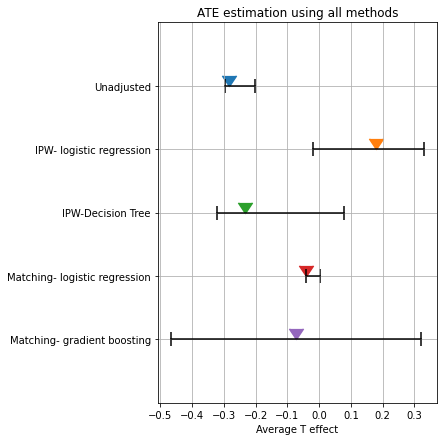

In [26]:
#plot all CI
plt.figure(figsize=(5,7))
plt.title("ATE estimation using all methods")
plt.scatter([unadjusted_ate], [4], marker=7, s=200)
plt.scatter(ci_naive, [4,4], marker="|", c='black', s=200)
plt.plot(ci_naive, [4,4], c='black')
plt.scatter([ate_ipw_lr_hat], [3], marker=7, s=200)
plt.scatter(ci_ipw_lr, [3,3], marker="|", c='black', s=200)
plt.plot(ci_ipw_lr, [3,3], c='black')
plt.scatter([ate_ipw_dt_hat], [2], marker=7, s=200)
plt.scatter(ci_dt, [2,2], marker="|", c='black', s=200)
plt.plot(ci_dt, [2,2], c='black')
plt.scatter([ate_hat_lr_m], [1], marker=7, s=200)
plt.scatter(ci_m_lr, [1,1], marker="|", c='black', s=200)
plt.plot(ci_m_lr, [1,1], c='black')
plt.scatter([ate_gb], [0], marker=7, s=200)
plt.scatter(ci_gb, [0,0], marker="|", c='black', s=200)
plt.plot(ci_gb, [0,0], c='black')
plt.xlabel("Average T effect")
plt.yticks(range(4+1), ['Matching- gradient boosting', 'Matching- logistic regression', 'IPW-Decision Tree', 'IPW- logistic regression', 'Unadjusted'])
plt.ylim((-1, 5))
plt.grid(True, "both")

plt.show()